# Neighborhood Effects of Trade in Landlocked Countries

The data set was part of my undergraduate senior project. The dataset contains data for 30 landlocked coutries over five years from 2014 to 2018. The data was obtained from the World Bank's World Development Indicators database and its World Inegrated Trade Services database. The goal of the project was to look at the effects of trade with neighboring countries on the economic level of a landlocked country.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# User-defined Methods

These methods were created in order to handle repitive tasks and also to make the code more readable.

In [118]:
# change column into categorical
def set_as_category(df, col):
    df[col] = df[col].astype("category")
    return df

# remap values of income level
def refactor_income(df):
    mapping={'H': '1', 'UM': '1', 'LM': '0', 'L': '0'}
    df['income'] = df['income'].map(mapping)
    return df

# increase number of rows; change year from columns to rows
def melt(df, col_name):
    return pd.melt(df, id_vars = 'Country Code', value_vars = range(2014, 2019), var_name = 'year', value_name = col_name)

# make sure that column header for years are the same
def rename_fy_year(df):
    for col in df.columns:
        if col[slice(4)].isdigit():
            df.rename(columns = {col:int(col[slice(4)])}, inplace = True)

    return df

# function that changes non-numeric values to NAN
def non_num_na(df):
    for i in df.columns[2:]:
        df[i] = pd.to_numeric(df[i], errors = 'coerce')
    return df

## Data exploration

An array was created with the names of data frames and a for loop was used to read all the files to the data frames.

In [119]:
tables = ['gdp_pc', 'inflation', 'trade_pct', 'unemployment', 'income', 'total_export', 'export_neighbors', 'import_neighbors']

# loop to create dataframes from csv files
for table in tables:
    locals()[table] = pd.read_csv("datafiles/" + table + ".csv")\
        .pipe(rename_fy_year)\
        .pipe(melt, col_name = table)\
        .sort_values(by = ['Country Code', 'year'])

### Dependent Variable

Gross Domestic Product per capita (`gdp_pc`) is the dependent variable that is used. It was chosen as the dependent variable because it is the key economic indicator for the economic level of a country.

### External factors

Non-neighborhood trade factors were also used in the analysis to avoid ommitted variable bias.

`inflation` and `unemployment` are key indicators of the health of economy and a high value for either could negatively effect the GDP per capita.

Trade as a percent of GDP (`trade_pct`) represents the overall trade activity of the country and a higher trade activity is associated with a higher GDP.

The income level (`income`) of a country could also effect the overall economy of a country as it is often true that higher income countries are close together which would mean that trading with neighboring countries would have high benefits for them.

### Neighborhood trade factors

`trade_ratio` and `trade_share` were created as indices to quantify the trade of a landlocked countries with their neighboring countries.

`trade_ratio` is calculated as $\frac{export\_neighbors}{import\_neighbors}$ and is the ratio of export and import with neighboring countries. A value of greater than $1$ indicates that this a landlocked country exports more to it neighbors than it imports from them and a value less than $1$ indicates the opposite.

`trade_share` is calculates as $\frac{export\_neighbors}{total\_export}$ and is the ratio of export to neighboring countries and the overall export by a landlocked country. A higher value indicates that the share of trade with neighboring countries is high for the landlocked country.

In [120]:
trade = pd.merge(total_export, export_neighbors)
trade = pd.merge(trade, import_neighbors)

# calculate trade_ratio and trade_share
trade['trade_ratio'] = trade.export_neighbors / trade.import_neighbors
trade['trade_share'] = trade.export_neighbors / trade.total_export
trade = trade.drop(['total_export', 'export_neighbors', 'import_neighbors'], axis = 1)

# Joining Tables

The separate tables are joined using the `dataFrame.merge()` method. Complete data was unavailable for some countries, so the last available data was used to fill this gap using the `.fillna(method="ffill")` method.

In [121]:
# merge into a single dataframe
landlocked = pd.merge(gdp_pc, trade)
landlocked = pd.merge(landlocked, inflation)
landlocked = pd.merge(landlocked, trade_pct)
landlocked = pd.merge(landlocked, unemployment)
landlocked = pd.merge(landlocked, income)\
    .pipe(set_as_category, col = 'Country Code')\
    .pipe(set_as_category, col = 'year')\
    .pipe(refactor_income)\
    .pipe(set_as_category, col = 'income')\
    .pipe(non_num_na)\
    .fillna(method="ffill")

landlocked.rename(columns = {'Country Code': 'country_code'}, inplace = True)
landlocked = landlocked.set_index(["country_code", "year"])

# write to file
landlocked.to_csv("datafiles/landlocked.csv")

landlocked.head(20)

gdp_pc  trade_ratio  trade_share  inflation  \
country_code year                                                      
ARM          2014   3986.231624     0.294647     0.100549   2.981309   
             2015   3607.289299     0.489140     0.132610   3.731691   
             2016   3591.828052     0.495953     0.118256  -1.403608   
             2017   3914.527854     0.480716     0.108976   0.969553   
             2018   4220.540321     0.279415     0.069629   2.520234   
AUT          2014  51786.377175     0.863429     0.515255   1.605812   
             2015  44195.817595     0.875840     0.521274   0.896563   
             2016  45307.587862     0.869716     0.529833   0.891592   
             2017  47429.158456     0.859066     0.521671   2.081269   
             2018  51486.575501     0.886570     0.526854   1.998380   
AZE          2014   7891.313147     0.602271     0.078695   1.373442   
             2015   5500.310382     0.885899     0.191793   4.027686   
             2016   3880.738731     0.676902     0.154045  12.443375   
             2017   4147.089716     0.791492     0.162379  12.935918   
             2018   4739.841710     0.761063     0.154981   2.268547   
BDI          2014    274.857836     0.548392     0.265477   4.405352   
             2015    305.511144     0.659316     0.308381   5.544689   
             2016    251.651477     0.501177     0.278487   5.557690   
             2017    250.514601     0.449103     0.203391  16.052535   
             2018    238.034310     0.460904     0.158862  -2.814698   

                    trade_pct  unemployment  income  
country_code year                                    
ARM          2014   75.778867     17.500000       0  
             2015   71.682074     18.260000       0  
             2016   76.077967     17.620001       0  
             2017   87.202377     17.700001       1  
             2018   92.473107     18.969999       1  
AUT          2014  103.503535      5.620000       1  
             2015  102.427315      5.720000       1  
             2016  100.982078      6.010000       1  
             2017  104.938845      5.500000       1  
             2018  107.881677      4.850000       1  
AZE          2014   69.483225      4.910000       1  
             2015   72.601508      4.960000       1  
             2016   90.077319      5.000000       1  
             2017   90.402316      5.000000       1  
             2018   91.672577      4.900000       1  
BDI          2014   42.995026      1.570000       0  
             2015   22.838283      1.600000       0  
             2016   23.043725      1.590000       0  
             2017   22.240293      1.589000       0  
             2018   26.599702      1.587000       0

## Summary Statistics

The dataset is divied into two groups; high income and low income. The project is focused on landlocked developing countries so comparison between the two groups will provide some key insights into their different economic levels.

In [122]:
landlocked_2018 = landlocked.xs(2018, level='year')
low_2018 = landlocked_2018[landlocked_2018.income == 0]
high_2018 = landlocked_2018[landlocked_2018.income == 1]

low_income = landlocked.loc[low_2018.index]
high_income = landlocked.loc[high_2018.index]

The summary statistics of the two groups indicates that the `trade_share` with neighboring countries is higher for low-income countries while `trade_ratio` and `trade_pct` is higher for high-income countries. This shows that high income countries have better terms of trade as well as higher levels of trade while low income countries are more reliant on their neighboring countries for trade.

In [123]:
hi_mean = pd.DataFrame(data={'hi_mean':high_income.mean(numeric_only = True)})
low_mean = pd.DataFrame(data={'low_mean':low_income.mean(numeric_only = True)})
hi_std = pd.DataFrame(data={'hi_std':high_income.std(numeric_only = True)})
low_std = pd.DataFrame(data={'low_std':low_income.std(numeric_only = True)})

pd.concat([hi_mean, hi_std, low_mean, low_std], axis = 1)

,hi_mean,hi_std,low_mean,low_std
gdp_pc,24865.250616,32951.527375,1652.562951,1228.731090
trade_ratio,0.873736,0.379170,0.781370,0.554147
trade_share,0.332471,0.163835,0.420694,0.265663
inflation,3.029948,3.915753,5.023958,3.982547
trade_pct,129.517601,70.959226,69.527172,30.504641
unemployment,9.660457,6.889170,6.462813,6.883290
income,0.957143,0.203997,0.012500,0.111803


### Correlation Matrix

The correlation matrix does not identify any dependent variables that are highly correlated with each other. `trade_pct` and `income` are moderately correlated which supports the earlier assumption that high income countries have an easier time trading.

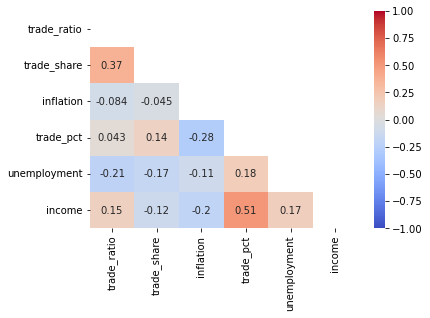

In [124]:
corr_matrix = landlocked.drop(['gdp_pc'], axis = 1).corr().round(3)
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
sns.heatmap(corr_matrix, annot = True, vmax = 1, vmin = -1, center = 0, cmap = 'coolwarm', mask = mask)
plt.show()

## Regression

The following regression model was used to look at the effect on GDP per capita of a landlocked country.

$$log(gdp\_pc_{i,t}) = \beta_{0} + \beta_{1}\;trade\_share_{i,t} + \beta_{2}\;trade\_ratio_{i,t} + \beta_{3}\;trade\_pct_{i,t} + \beta_{4}\;income_{i, t} + \beta_{5}\;inflation_{i, t} + \beta_{7}\;unemployment_{i, t} + \epsilon_{i,t}$$